In [78]:
# [0단계] 실험 개요 및 데이터셋 설명
# - 실험 목적, 데이터셋, 클래스 정보 등 전체 실험의 개요를 설명합니다.
# - IQ-OTH_NCCD 폐암 데이터셋(3-class: Benign, Malignant, Normal) 사용
# - 비교 모델: ['resnet18', 'resnet50', 'densenet121', 'densenet169']

# The IQ-OTH_NCCD lung cancer dataset
# https://www.kaggle.com/datasets/hamdallak/the-iqothnccd-lung-cancer-dataset/code

# Normal(정상)
# Malignant (악성) : 악성 종양, 즉 암. 
# Benign (양성) : 양성 종양, 즉 암이 아닌 종양.


In [86]:
# [Cell 1] 환경 설정 및 라이브러리 임포트

import os
import shutil
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score, f1_score
from tqdm.auto import tqdm

# 1. 재현성 보장 (Seed 고정: 2026)
# 실험 결과를 신뢰할 수 있도록 난수 생성 규칙을 고정합니다.
def set_seed(seed=2026):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed()

# 2. 장치 설정 (GPU 우선 사용)
# CUDA(NVIDIA GPU)가 있으면 사용하고, 없으면 CPU를 사용합니다.
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Current Device: {DEVICE}")

# 3. 결과 저장 폴더 생성
# 실험 결과(CSV, 이미지, 모델 가중치)를 저장할 폴더를 만듭니다.
os.makedirs('./Result_Comparison', exist_ok=True)

Current Device: cuda


In [80]:
# [Cell 2] 데이터셋 물리적 분할 및 복사
DATA_DIR = './Data'  # 원본 데이터 폴더
SPLIT_DIR = './Data_split'     # 분할된 데이터가 저장될 폴더
SPLIT_RATIO = (0.7, 0.1, 0.2)  # Train : Valid : Test

def split_dataset_physically():
    print(">> 데이터셋 분할 작업 시작...")
    
    # 1. 기존 Data_split 폴더가 있다면 삭제 후 재생성 (Reset)
    if os.path.exists(SPLIT_DIR):
        print(f"   기존 폴더 삭제 중: {SPLIT_DIR}")
        shutil.rmtree(SPLIT_DIR)
    
    os.makedirs(SPLIT_DIR)
    
    # 각 분할(Train, Valid, Test)을 위한 서브 폴더 생성
    for split in ['train', 'valid', 'test']:
        os.makedirs(os.path.join(SPLIT_DIR, split))

    # 2. 클래스별로 파일 읽어오기 및 분할
    try:
        classes = [d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d))]
    except FileNotFoundError:
        print(f"오류: 원본 데이터 폴더({DATA_DIR})를 찾을 수 없습니다.")
        return

    for class_name in classes:
        # 각 분할 폴더 안에 클래스 폴더 생성
        for split in ['train', 'valid', 'test']:
            os.makedirs(os.path.join(SPLIT_DIR, split, class_name), exist_ok=True)
            
        # 원본 이미지 리스트 가져오기
        src_path = os.path.join(DATA_DIR, class_name)
        images = [f for f in os.listdir(src_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        # 랜덤 셔플 (Seed 2026 영향 받음)
        random.shuffle(images)
        
        # 개수 계산
        total_count = len(images)
        train_count = int(total_count * SPLIT_RATIO[0])
        valid_count = int(total_count * SPLIT_RATIO[1])
        test_count = total_count - train_count - valid_count
        
        # 슬라이싱으로 나누기
        train_imgs = images[:train_count]
        valid_imgs = images[train_count : train_count + valid_count]
        test_imgs = images[train_count + valid_count :]
        
        # 파일 복사
        for img in tqdm(train_imgs, desc=f"Copying {class_name} (Train)", leave=False):
            shutil.copy(os.path.join(src_path, img), os.path.join(SPLIT_DIR, 'train', class_name, img))
            
        for img in tqdm(valid_imgs, desc=f"Copying {class_name} (Valid)", leave=False):
            shutil.copy(os.path.join(src_path, img), os.path.join(SPLIT_DIR, 'valid', class_name, img))
            
        for img in tqdm(test_imgs, desc=f"Copying {class_name} (Test)", leave=False):
            shutil.copy(os.path.join(src_path, img), os.path.join(SPLIT_DIR, 'test', class_name, img))
            
        print(f"   [{class_name}] 완료 | Train: {len(train_imgs)}, Valid: {len(valid_imgs)}, Test: {len(test_imgs)}")

    print(">> 모든 데이터셋 분할 및 복사가 완료되었습니다!\n")

# 실행
split_dataset_physically()

>> 데이터셋 분할 작업 시작...
   기존 폴더 삭제 중: ./Data_split


Copying Benign cases (Train):   0%|          | 0/84 [00:00<?, ?it/s]

Copying Benign cases (Valid):   0%|          | 0/12 [00:00<?, ?it/s]

Copying Benign cases (Test):   0%|          | 0/24 [00:00<?, ?it/s]

   [Benign cases] 완료 | Train: 84, Valid: 12, Test: 24


Copying Malignant cases (Train):   0%|          | 0/392 [00:00<?, ?it/s]

Copying Malignant cases (Valid):   0%|          | 0/56 [00:00<?, ?it/s]

Copying Malignant cases (Test):   0%|          | 0/113 [00:00<?, ?it/s]

   [Malignant cases] 완료 | Train: 392, Valid: 56, Test: 113


Copying Normal cases (Train):   0%|          | 0/291 [00:00<?, ?it/s]

Copying Normal cases (Valid):   0%|          | 0/41 [00:00<?, ?it/s]

Copying Normal cases (Test):   0%|          | 0/84 [00:00<?, ?it/s]

   [Normal cases] 완료 | Train: 291, Valid: 41, Test: 84
>> 모든 데이터셋 분할 및 복사가 완료되었습니다!



In [81]:
# [Cell 3] 분할된 데이터 로드
SPLIT_DIR = './Data_split'

# 이미지 전처리 파이프라인
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

try:
    # ImageFolder로 각 폴더 로드
    train_dataset = datasets.ImageFolder(root=os.path.join(SPLIT_DIR, 'train'), transform=data_transforms)
    valid_dataset = datasets.ImageFolder(root=os.path.join(SPLIT_DIR, 'valid'), transform=data_transforms)
    test_dataset = datasets.ImageFolder(root=os.path.join(SPLIT_DIR, 'test'), transform=data_transforms)
    
    class_names = train_dataset.classes
    num_classes = len(class_names)
    print(f"분류 클래스: {class_names}")

    # 데이터 로더 생성
    BATCH_SIZE = 32
    dataloaders = {
        'train': DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True),
        'valid': DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False),
        'test': DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    }
    
    print(f"데이터 로드 완료:")
    print(f"- Train: {len(train_dataset)}장")
    print(f"- Valid: {len(valid_dataset)}장")
    print(f"- Test : {len(test_dataset)}장")

except Exception as e:
    print(f"오류: Data_split 폴더를 찾을 수 없습니다. Cell 2를 먼저 실행하세요.\n{e}")

분류 클래스: ['Benign cases', 'Malignant cases', 'Normal cases']
데이터 로드 완료:
- Train: 767장
- Valid: 109장
- Test : 221장


In [82]:
# [Cell 4] Model Factory Definition
class ModelFactory:
    @staticmethod
    def get_model(model_name, num_classes):
        model_name = model_name.lower()
        model = None
        
        # ResNet Family
        if model_name == 'resnet18':
            model = models.resnet18(weights='DEFAULT')
            model.fc = nn.Linear(model.fc.in_features, num_classes)
        elif model_name == 'resnet50':
            model = models.resnet50(weights='DEFAULT')
            model.fc = nn.Linear(model.fc.in_features, num_classes)
            
        # DenseNet Family
        elif model_name == 'densenet121':
            model = models.densenet121(weights='DEFAULT')
            model.classifier = nn.Linear(model.classifier.in_features, num_classes)
        elif model_name == 'densenet169':
            model = models.densenet169(weights='DEFAULT')
            model.classifier = nn.Linear(model.classifier.in_features, num_classes)
            
        else:
            raise ValueError(f"Unknown model: {model_name}")
            
        return model.to(DEVICE)

In [111]:
# [Cell 5] Training & Metrics Function (누적 시간 기록 포함)
from tqdm.auto import tqdm
import time
import pandas as pd

def calculate_metrics(y_true, y_pred):
    """Confusion Matrix 기반 상세 지표 계산"""
    cm = confusion_matrix(y_true, y_pred)
    
    FP = cm.sum(axis=0) - np.diag(cm)  
    FN = cm.sum(axis=1) - np.diag(cm)
    TP = np.diag(cm)
    TN = cm.sum() - (FP + FN + TP)
    
    TP_total, TN_total = TP.sum(), TN.sum()
    FP_total, FN_total = FP.sum(), FN.sum()
    
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted', zero_division=0)
    acc = accuracy_score(y_true, y_pred)
    
    return TP_total, TN_total, FP_total, FN_total, acc, precision, recall, f1

def train_model(model_name, dataloaders, num_classes, epochs=20):
    model = ModelFactory.get_model(model_name, num_classes)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0)
    
    history = []
    best_f1 = 0.0
    
    # [1] 전체 학습 시작 시간 기록
    start_time_global = time.time()
    
    print(f"\n>> [{model_name.upper()}] Training Start ({epochs} Epochs)...")
    
    for epoch in range(1, epochs + 1):
        # --- Train ---
        model.train()
        train_loss = 0.0
        
        pbar = tqdm(dataloaders['train'], desc=f"Ep {epoch} Train", leave=False)
        for inputs, labels in pbar:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
            pbar.set_postfix({'loss': f"{loss.item():.4f}"})
            
        scheduler.step()
        train_loss /= len(dataloaders['train'].dataset)
        
        # --- Valid ---
        model.eval()
        valid_loss = 0.0
        val_preds = []
        val_labels = []
        
        with torch.no_grad():
            for inputs, labels in dataloaders['valid']:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                valid_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
        
        valid_loss /= len(dataloaders['valid'].dataset)
        
        # 상세 지표 계산
        TP, TN, FP, FN, val_acc, val_prec, val_rec, val_f1 = calculate_metrics(val_labels, val_preds)
        
        # [2] 누적 소요 시간 계산 (현재 시간 - 시작 시간)
        cumulative_time = time.time() - start_time_global
        
        print(f"Ep {epoch}/{epochs} | T-Loss: {train_loss:.4f} | V-Loss: {valid_loss:.4f} | Acc: {val_acc:.4f} | F1: {val_f1:.4f} | Time: {cumulative_time:.1f}s")
        
        # [3] 기록 저장 (Cumulative_Time 컬럼 추가)
        history.append({
            'epoch': epoch, 
            'model': model_name,
            'train_loss': train_loss, 
            'valid_loss': valid_loss,
            'TP': TP, 'TN': TN, 'FP': FP, 'FN': FN,
            'Accuracy': val_acc, 
            'Precision': val_prec, 
            'Recall': val_rec, 
            'F1_score': val_f1,
            'Cumulative_Time': cumulative_time  # <--- 여기에 저장됨
        })
        
        if val_f1 > best_f1:
            best_f1 = val_f1
            torch.save(model.state_dict(), f'./Result_Comparison/best_{model_name}.pth')
            
    # [4] CSV 파일로 저장
    df = pd.DataFrame(history)
    save_path = f'./Result_Comparison/{model_name}_metrics.csv'
    df.to_csv(save_path, index=False)
    print(f">> {model_name} Finished. CSV saved to {save_path}")

In [ ]:
# [Cell 6] Main Execution Loop
models_to_compare = ['resnet18', 'resnet50', 'densenet121', 'densenet169']
EPOCHS = 15

print("=== 4 Model Comparison Experiment Start ===")

for name in models_to_compare:
    train_model(name, dataloaders, num_classes=len(class_names), epochs=EPOCHS)
    torch.cuda.empty_cache() # GPU 메모리 정리

print("\n=== All Experiments Completed ===")

=== 4 Model Comparison Experiment Start ===

>> [RESNET18] Training Start (20 Epochs)...


Ep 1 Train:   0%|          | 0/24 [00:00<?, ?it/s]

Ep 1/20 | T-Loss: 0.3226 | V-Loss: 0.2092 | Acc: 0.8899 | F1: 0.8409 | Time: 4.6s


Ep 2 Train:   0%|          | 0/24 [00:00<?, ?it/s]

Ep 2/20 | T-Loss: 0.0445 | V-Loss: 0.1177 | Acc: 0.9541 | F1: 0.9494 | Time: 8.8s


Ep 3 Train:   0%|          | 0/24 [00:00<?, ?it/s]

Ep 3/20 | T-Loss: 0.0172 | V-Loss: 0.0155 | Acc: 1.0000 | F1: 1.0000 | Time: 13.1s


Ep 4 Train:   0%|          | 0/24 [00:00<?, ?it/s]

Ep 4/20 | T-Loss: 0.0080 | V-Loss: 0.0358 | Acc: 0.9817 | F1: 0.9817 | Time: 17.3s


Ep 5 Train:   0%|          | 0/24 [00:00<?, ?it/s]

Ep 5/20 | T-Loss: 0.0026 | V-Loss: 0.0149 | Acc: 1.0000 | F1: 1.0000 | Time: 21.5s


Ep 6 Train:   0%|          | 0/24 [00:00<?, ?it/s]

Ep 6/20 | T-Loss: 0.0018 | V-Loss: 0.0144 | Acc: 0.9908 | F1: 0.9907 | Time: 25.8s


Ep 7 Train:   0%|          | 0/24 [00:00<?, ?it/s]

Ep 7/20 | T-Loss: 0.0017 | V-Loss: 0.0132 | Acc: 1.0000 | F1: 1.0000 | Time: 30.1s


Ep 8 Train:   0%|          | 0/24 [00:00<?, ?it/s]

Ep 8/20 | T-Loss: 0.0014 | V-Loss: 0.0131 | Acc: 0.9908 | F1: 0.9907 | Time: 34.3s


Ep 9 Train:   0%|          | 0/24 [00:00<?, ?it/s]

Ep 9/20 | T-Loss: 0.0011 | V-Loss: 0.0118 | Acc: 0.9908 | F1: 0.9907 | Time: 38.6s


Ep 10 Train:   0%|          | 0/24 [00:00<?, ?it/s]

Ep 10/20 | T-Loss: 0.0008 | V-Loss: 0.0111 | Acc: 1.0000 | F1: 1.0000 | Time: 42.8s


Ep 11 Train:   0%|          | 0/24 [00:00<?, ?it/s]

Ep 11/20 | T-Loss: 0.0007 | V-Loss: 0.0107 | Acc: 1.0000 | F1: 1.0000 | Time: 47.1s


Ep 12 Train:   0%|          | 0/24 [00:00<?, ?it/s]

Ep 12/20 | T-Loss: 0.0010 | V-Loss: 0.0098 | Acc: 1.0000 | F1: 1.0000 | Time: 51.4s


Ep 13 Train:   0%|          | 0/24 [00:00<?, ?it/s]

Ep 13/20 | T-Loss: 0.0010 | V-Loss: 0.0083 | Acc: 1.0000 | F1: 1.0000 | Time: 55.6s


Ep 14 Train:   0%|          | 0/24 [00:00<?, ?it/s]

Ep 14/20 | T-Loss: 0.0007 | V-Loss: 0.0097 | Acc: 1.0000 | F1: 1.0000 | Time: 59.9s


Ep 15 Train:   0%|          | 0/24 [00:00<?, ?it/s]

Ep 15/20 | T-Loss: 0.0008 | V-Loss: 0.0089 | Acc: 1.0000 | F1: 1.0000 | Time: 64.1s


Ep 16 Train:   0%|          | 0/24 [00:00<?, ?it/s]

Ep 16/20 | T-Loss: 0.0007 | V-Loss: 0.0101 | Acc: 1.0000 | F1: 1.0000 | Time: 68.4s


Ep 17 Train:   0%|          | 0/24 [00:00<?, ?it/s]

Ep 17/20 | T-Loss: 0.0012 | V-Loss: 0.0092 | Acc: 1.0000 | F1: 1.0000 | Time: 72.7s


Ep 18 Train:   0%|          | 0/24 [00:00<?, ?it/s]

Ep 18/20 | T-Loss: 0.0007 | V-Loss: 0.0093 | Acc: 1.0000 | F1: 1.0000 | Time: 76.9s


Ep 19 Train:   0%|          | 0/24 [00:00<?, ?it/s]

Ep 19/20 | T-Loss: 0.0009 | V-Loss: 0.0105 | Acc: 1.0000 | F1: 1.0000 | Time: 81.2s


Ep 20 Train:   0%|          | 0/24 [00:00<?, ?it/s]

Ep 20/20 | T-Loss: 0.0009 | V-Loss: 0.0094 | Acc: 1.0000 | F1: 1.0000 | Time: 85.4s
>> resnet18 Finished. CSV saved.

>> [RESNET50] Training Start (20 Epochs)...


Ep 1 Train:   0%|          | 0/24 [00:00<?, ?it/s]

Ep 1/20 | T-Loss: 0.5969 | V-Loss: 0.3921 | Acc: 0.8716 | F1: 0.8228 | Time: 7.3s


Ep 2 Train:   0%|          | 0/24 [00:00<?, ?it/s]

Ep 2/20 | T-Loss: 0.1940 | V-Loss: 0.2301 | Acc: 0.8899 | F1: 0.8419 | Time: 14.7s


Ep 3 Train:   0%|          | 0/24 [00:00<?, ?it/s]

Ep 3/20 | T-Loss: 0.0557 | V-Loss: 0.2061 | Acc: 0.9358 | F1: 0.9251 | Time: 22.1s


Ep 4 Train:   0%|          | 0/24 [00:00<?, ?it/s]

Ep 4/20 | T-Loss: 0.0196 | V-Loss: 0.0442 | Acc: 0.9908 | F1: 0.9907 | Time: 29.4s


Ep 5 Train:   0%|          | 0/24 [00:00<?, ?it/s]

Ep 5/20 | T-Loss: 0.0127 | V-Loss: 0.0925 | Acc: 0.9725 | F1: 0.9729 | Time: 36.7s


Ep 6 Train:   0%|          | 0/24 [00:00<?, ?it/s]

Ep 6/20 | T-Loss: 0.0042 | V-Loss: 0.0471 | Acc: 0.9725 | F1: 0.9720 | Time: 44.0s


Ep 7 Train:   0%|          | 0/24 [00:00<?, ?it/s]

Ep 7/20 | T-Loss: 0.0019 | V-Loss: 0.0389 | Acc: 0.9817 | F1: 0.9817 | Time: 51.3s


Ep 8 Train:   0%|          | 0/24 [00:00<?, ?it/s]

Ep 8/20 | T-Loss: 0.0018 | V-Loss: 0.0413 | Acc: 0.9817 | F1: 0.9817 | Time: 58.5s


Ep 9 Train:   0%|          | 0/24 [00:00<?, ?it/s]

Ep 9/20 | T-Loss: 0.0012 | V-Loss: 0.0394 | Acc: 0.9817 | F1: 0.9817 | Time: 66.0s


Ep 10 Train:   0%|          | 0/24 [00:00<?, ?it/s]

Ep 10/20 | T-Loss: 0.0010 | V-Loss: 0.0405 | Acc: 0.9725 | F1: 0.9720 | Time: 73.4s


Ep 11 Train:   0%|          | 0/24 [00:00<?, ?it/s]

Ep 11/20 | T-Loss: 0.0027 | V-Loss: 0.0424 | Acc: 0.9817 | F1: 0.9817 | Time: 80.7s


Ep 12 Train:   0%|          | 0/24 [00:00<?, ?it/s]

Ep 12/20 | T-Loss: 0.0019 | V-Loss: 0.0401 | Acc: 0.9817 | F1: 0.9817 | Time: 88.2s


Ep 13 Train:   0%|          | 0/24 [00:00<?, ?it/s]

Ep 13/20 | T-Loss: 0.0035 | V-Loss: 0.0600 | Acc: 0.9817 | F1: 0.9817 | Time: 95.7s


Ep 14 Train:   0%|          | 0/24 [00:00<?, ?it/s]

Ep 14/20 | T-Loss: 0.0009 | V-Loss: 0.0521 | Acc: 0.9817 | F1: 0.9817 | Time: 103.1s


Ep 15 Train:   0%|          | 0/24 [00:00<?, ?it/s]

Ep 15/20 | T-Loss: 0.0010 | V-Loss: 0.0408 | Acc: 0.9817 | F1: 0.9817 | Time: 110.6s


Ep 16 Train:   0%|          | 0/24 [00:00<?, ?it/s]

Ep 16/20 | T-Loss: 0.0007 | V-Loss: 0.0461 | Acc: 0.9817 | F1: 0.9817 | Time: 118.1s


Ep 17 Train:   0%|          | 0/24 [00:00<?, ?it/s]

Ep 17/20 | T-Loss: 0.0016 | V-Loss: 0.0382 | Acc: 0.9817 | F1: 0.9817 | Time: 125.7s


Ep 18 Train:   0%|          | 0/24 [00:00<?, ?it/s]

Ep 18/20 | T-Loss: 0.0016 | V-Loss: 0.0369 | Acc: 0.9817 | F1: 0.9817 | Time: 133.2s


Ep 19 Train:   0%|          | 0/24 [00:00<?, ?it/s]

Ep 19/20 | T-Loss: 0.0008 | V-Loss: 0.0367 | Acc: 0.9817 | F1: 0.9817 | Time: 140.7s


Ep 20 Train:   0%|          | 0/24 [00:00<?, ?it/s]

Ep 20/20 | T-Loss: 0.0006 | V-Loss: 0.0421 | Acc: 0.9817 | F1: 0.9817 | Time: 148.2s
>> resnet50 Finished. CSV saved.

>> [DENSENET121] Training Start (20 Epochs)...


Ep 1 Train:   0%|          | 0/24 [00:00<?, ?it/s]

Ep 1/20 | T-Loss: 0.3872 | V-Loss: 0.2315 | Acc: 0.9266 | F1: 0.9193 | Time: 9.4s


Ep 2 Train:   0%|          | 0/24 [00:00<?, ?it/s]

Ep 2/20 | T-Loss: 0.0947 | V-Loss: 0.1254 | Acc: 0.9633 | F1: 0.9605 | Time: 18.8s


Ep 3 Train:   0%|          | 0/24 [00:00<?, ?it/s]

Ep 3/20 | T-Loss: 0.0287 | V-Loss: 0.0380 | Acc: 0.9908 | F1: 0.9907 | Time: 28.2s


Ep 4 Train:   0%|          | 0/24 [00:00<?, ?it/s]

Ep 4/20 | T-Loss: 0.0120 | V-Loss: 0.0593 | Acc: 0.9725 | F1: 0.9729 | Time: 37.9s


Ep 5 Train:   0%|          | 0/24 [00:00<?, ?it/s]

Ep 5/20 | T-Loss: 0.0172 | V-Loss: 0.0302 | Acc: 0.9908 | F1: 0.9907 | Time: 47.5s


Ep 6 Train:   0%|          | 0/24 [00:00<?, ?it/s]

Ep 6/20 | T-Loss: 0.0125 | V-Loss: 0.0318 | Acc: 0.9908 | F1: 0.9907 | Time: 55.5s


Ep 7 Train:   0%|          | 0/24 [00:00<?, ?it/s]

Ep 7/20 | T-Loss: 0.0077 | V-Loss: 0.0309 | Acc: 0.9908 | F1: 0.9907 | Time: 63.5s


Ep 8 Train:   0%|          | 0/24 [00:00<?, ?it/s]

Ep 8/20 | T-Loss: 0.0035 | V-Loss: 0.0388 | Acc: 0.9908 | F1: 0.9907 | Time: 71.6s


Ep 9 Train:   0%|          | 0/24 [00:00<?, ?it/s]

Ep 9/20 | T-Loss: 0.0033 | V-Loss: 0.0285 | Acc: 0.9908 | F1: 0.9907 | Time: 79.6s


Ep 10 Train:   0%|          | 0/24 [00:00<?, ?it/s]

Ep 10/20 | T-Loss: 0.0030 | V-Loss: 0.0273 | Acc: 0.9908 | F1: 0.9907 | Time: 87.6s


Ep 11 Train:   0%|          | 0/24 [00:00<?, ?it/s]

Ep 11/20 | T-Loss: 0.0022 | V-Loss: 0.0272 | Acc: 0.9908 | F1: 0.9907 | Time: 95.6s


Ep 12 Train:   0%|          | 0/24 [00:00<?, ?it/s]

Ep 12/20 | T-Loss: 0.0023 | V-Loss: 0.0294 | Acc: 0.9908 | F1: 0.9907 | Time: 104.4s


Ep 13 Train:   0%|          | 0/24 [00:00<?, ?it/s]

Ep 13/20 | T-Loss: 0.0024 | V-Loss: 0.0308 | Acc: 0.9908 | F1: 0.9907 | Time: 112.7s


Ep 14 Train:   0%|          | 0/24 [00:00<?, ?it/s]

Ep 14/20 | T-Loss: 0.0023 | V-Loss: 0.0265 | Acc: 0.9908 | F1: 0.9907 | Time: 120.7s


Ep 15 Train:   0%|          | 0/24 [00:00<?, ?it/s]

Ep 15/20 | T-Loss: 0.0021 | V-Loss: 0.0332 | Acc: 0.9908 | F1: 0.9907 | Time: 128.7s


Ep 16 Train:   0%|          | 0/24 [00:00<?, ?it/s]

Ep 16/20 | T-Loss: 0.0016 | V-Loss: 0.0338 | Acc: 0.9908 | F1: 0.9907 | Time: 137.0s


Ep 17 Train:   0%|          | 0/24 [00:00<?, ?it/s]

Ep 17/20 | T-Loss: 0.0023 | V-Loss: 0.0319 | Acc: 0.9908 | F1: 0.9907 | Time: 145.2s


Ep 18 Train:   0%|          | 0/24 [00:00<?, ?it/s]

Ep 18/20 | T-Loss: 0.0023 | V-Loss: 0.0310 | Acc: 0.9908 | F1: 0.9907 | Time: 153.2s


Ep 19 Train:   0%|          | 0/24 [00:00<?, ?it/s]

Ep 19/20 | T-Loss: 0.0015 | V-Loss: 0.0344 | Acc: 0.9908 | F1: 0.9907 | Time: 161.1s


Ep 20 Train:   0%|          | 0/24 [00:00<?, ?it/s]

Ep 20/20 | T-Loss: 0.0015 | V-Loss: 0.0373 | Acc: 0.9908 | F1: 0.9907 | Time: 169.0s
>> densenet121 Finished. CSV saved.


Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to C:\Users\sjowu/.cache\torch\hub\checkpoints\densenet169-b2777c0a.pth
100%|██████████| 54.7M/54.7M [00:03<00:00, 14.4MB/s]



>> [DENSENET169] Training Start (20 Epochs)...


Ep 1 Train:   0%|          | 0/24 [00:00<?, ?it/s]

Ep 1/20 | T-Loss: 0.3867 | V-Loss: 0.2073 | Acc: 0.8899 | F1: 0.8419 | Time: 9.2s


Ep 2 Train:   0%|          | 0/24 [00:00<?, ?it/s]

Ep 2/20 | T-Loss: 0.0652 | V-Loss: 0.0971 | Acc: 0.9725 | F1: 0.9720 | Time: 18.2s


Ep 3 Train:   0%|          | 0/24 [00:00<?, ?it/s]

Ep 3/20 | T-Loss: 0.0257 | V-Loss: 0.0726 | Acc: 0.9817 | F1: 0.9810 | Time: 27.3s


Ep 4 Train:   0%|          | 0/24 [00:00<?, ?it/s]

Ep 4/20 | T-Loss: 0.0124 | V-Loss: 0.0555 | Acc: 0.9817 | F1: 0.9817 | Time: 36.3s


Ep 5 Train:   0%|          | 0/24 [00:00<?, ?it/s]

Ep 5/20 | T-Loss: 0.0062 | V-Loss: 0.0157 | Acc: 0.9908 | F1: 0.9907 | Time: 45.4s


Ep 6 Train:   0%|          | 0/24 [00:00<?, ?it/s]

Ep 6/20 | T-Loss: 0.0032 | V-Loss: 0.0296 | Acc: 0.9908 | F1: 0.9907 | Time: 54.5s


Ep 7 Train:   0%|          | 0/24 [00:00<?, ?it/s]

Ep 7/20 | T-Loss: 0.0026 | V-Loss: 0.0296 | Acc: 0.9908 | F1: 0.9907 | Time: 63.7s


Ep 8 Train:   0%|          | 0/24 [00:00<?, ?it/s]

Ep 8/20 | T-Loss: 0.0023 | V-Loss: 0.0279 | Acc: 0.9908 | F1: 0.9907 | Time: 72.9s


Ep 9 Train:   0%|          | 0/24 [00:00<?, ?it/s]

Ep 9/20 | T-Loss: 0.0024 | V-Loss: 0.0231 | Acc: 0.9908 | F1: 0.9907 | Time: 81.9s


Ep 10 Train:   0%|          | 0/24 [00:00<?, ?it/s]

Ep 10/20 | T-Loss: 0.0022 | V-Loss: 0.0333 | Acc: 0.9908 | F1: 0.9907 | Time: 90.9s


Ep 11 Train:   0%|          | 0/24 [00:00<?, ?it/s]

Ep 11/20 | T-Loss: 0.0018 | V-Loss: 0.0327 | Acc: 0.9908 | F1: 0.9907 | Time: 99.9s


Ep 12 Train:   0%|          | 0/24 [00:00<?, ?it/s]

Ep 12/20 | T-Loss: 0.0012 | V-Loss: 0.0282 | Acc: 0.9908 | F1: 0.9907 | Time: 108.9s


Ep 13 Train:   0%|          | 0/24 [00:00<?, ?it/s]

Ep 13/20 | T-Loss: 0.0019 | V-Loss: 0.0265 | Acc: 0.9908 | F1: 0.9907 | Time: 117.9s


Ep 14 Train:   0%|          | 0/24 [00:00<?, ?it/s]

Ep 14/20 | T-Loss: 0.0013 | V-Loss: 0.0401 | Acc: 0.9908 | F1: 0.9907 | Time: 126.8s


Ep 15 Train:   0%|          | 0/24 [00:00<?, ?it/s]

Ep 15/20 | T-Loss: 0.0035 | V-Loss: 0.0331 | Acc: 0.9908 | F1: 0.9907 | Time: 135.7s


Ep 16 Train:   0%|          | 0/24 [00:00<?, ?it/s]

Ep 16/20 | T-Loss: 0.0015 | V-Loss: 0.0359 | Acc: 0.9908 | F1: 0.9907 | Time: 144.6s


Ep 17 Train:   0%|          | 0/24 [00:00<?, ?it/s]

Ep 17/20 | T-Loss: 0.0016 | V-Loss: 0.0374 | Acc: 0.9908 | F1: 0.9907 | Time: 153.6s


Ep 18 Train:   0%|          | 0/24 [00:00<?, ?it/s]

Ep 18/20 | T-Loss: 0.0017 | V-Loss: 0.0334 | Acc: 0.9908 | F1: 0.9907 | Time: 162.5s


Ep 19 Train:   0%|          | 0/24 [00:00<?, ?it/s]

Ep 19/20 | T-Loss: 0.0011 | V-Loss: 0.0311 | Acc: 0.9908 | F1: 0.9907 | Time: 171.5s


Ep 20 Train:   0%|          | 0/24 [00:00<?, ?it/s]

Ep 20/20 | T-Loss: 0.0017 | V-Loss: 0.0316 | Acc: 0.9908 | F1: 0.9907 | Time: 180.6s
>> densenet169 Finished. CSV saved.

=== All Experiments Completed ===


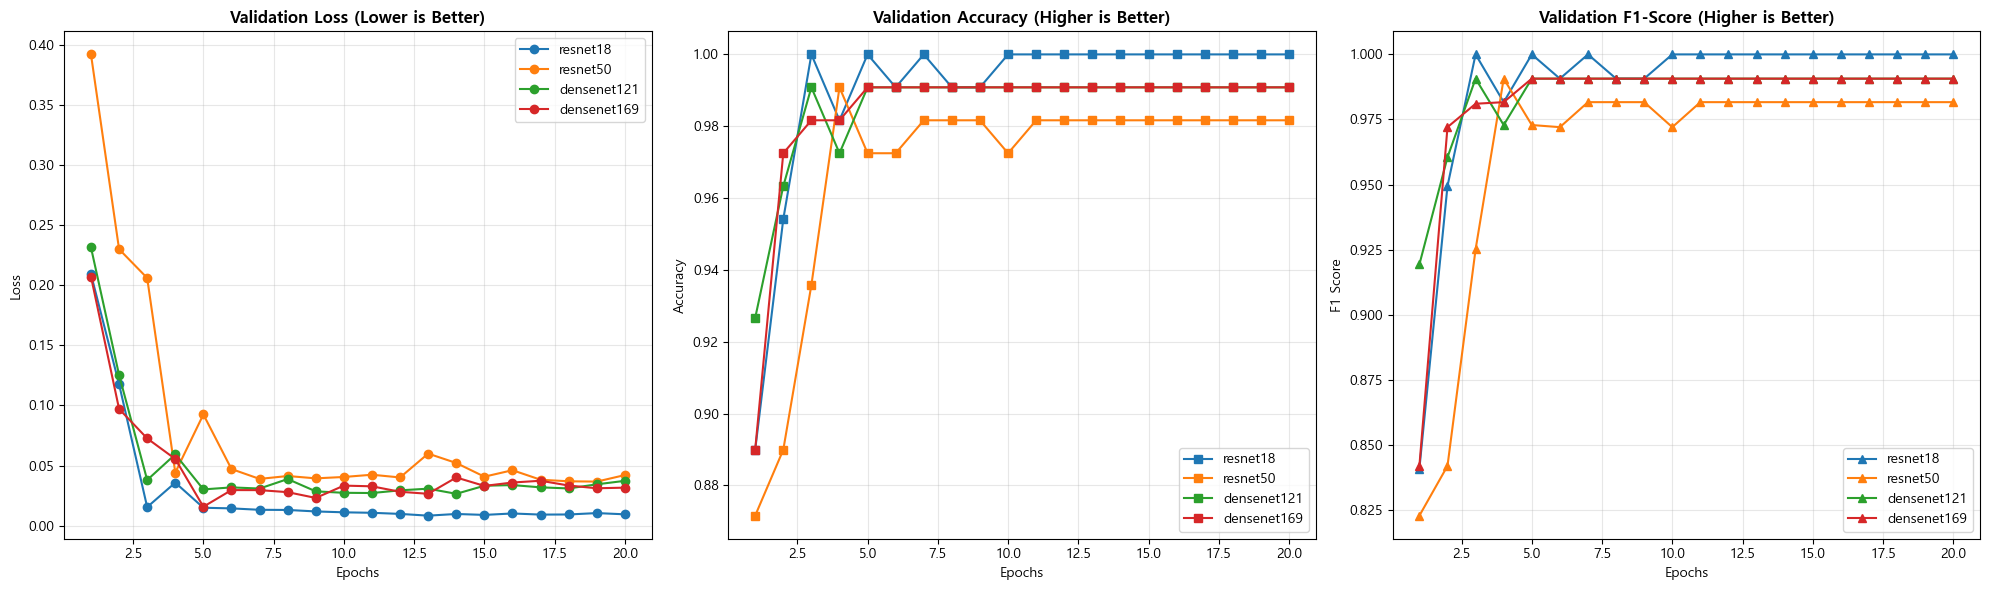

In [91]:
# [Cell 7] Plot Metrics Comparison
def plot_metrics_comparison():
    models = ['resnet18', 'resnet50', 'densenet121', 'densenet169']
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    for name in models:
        csv_path = f'./Result_Comparison/{name}_metrics.csv'
        if not os.path.exists(csv_path): continue
        
        df = pd.read_csv(csv_path)
        axes[0].plot(df['epoch'], df['valid_loss'], marker='o', label=name)
        axes[1].plot(df['epoch'], df['Accuracy'], marker='s', label=name)
        axes[2].plot(df['epoch'], df['F1_score'], marker='^', label=name)
    
    titles = ['Validation Loss (Lower is Better)', 'Validation Accuracy (Higher is Better)', 'Validation F1-Score (Higher is Better)']
    ylabels = ['Loss', 'Accuracy', 'F1 Score']
    
    for i, ax in enumerate(axes):
        ax.set_title(titles[i], fontweight='bold')
        ax.set_xlabel('Epochs')
        ax.set_ylabel(ylabels[i])
        ax.grid(True, alpha=0.3)
        ax.legend()

    plt.tight_layout()
    plt.savefig('./Result_Comparison/metrics_comparison.png')
    plt.show()

plot_metrics_comparison()

C:\Users\sjowu\AppData\Local\Temp\ipykernel_34656\570299798.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(pth_path))
C:\Users\sjowu\A

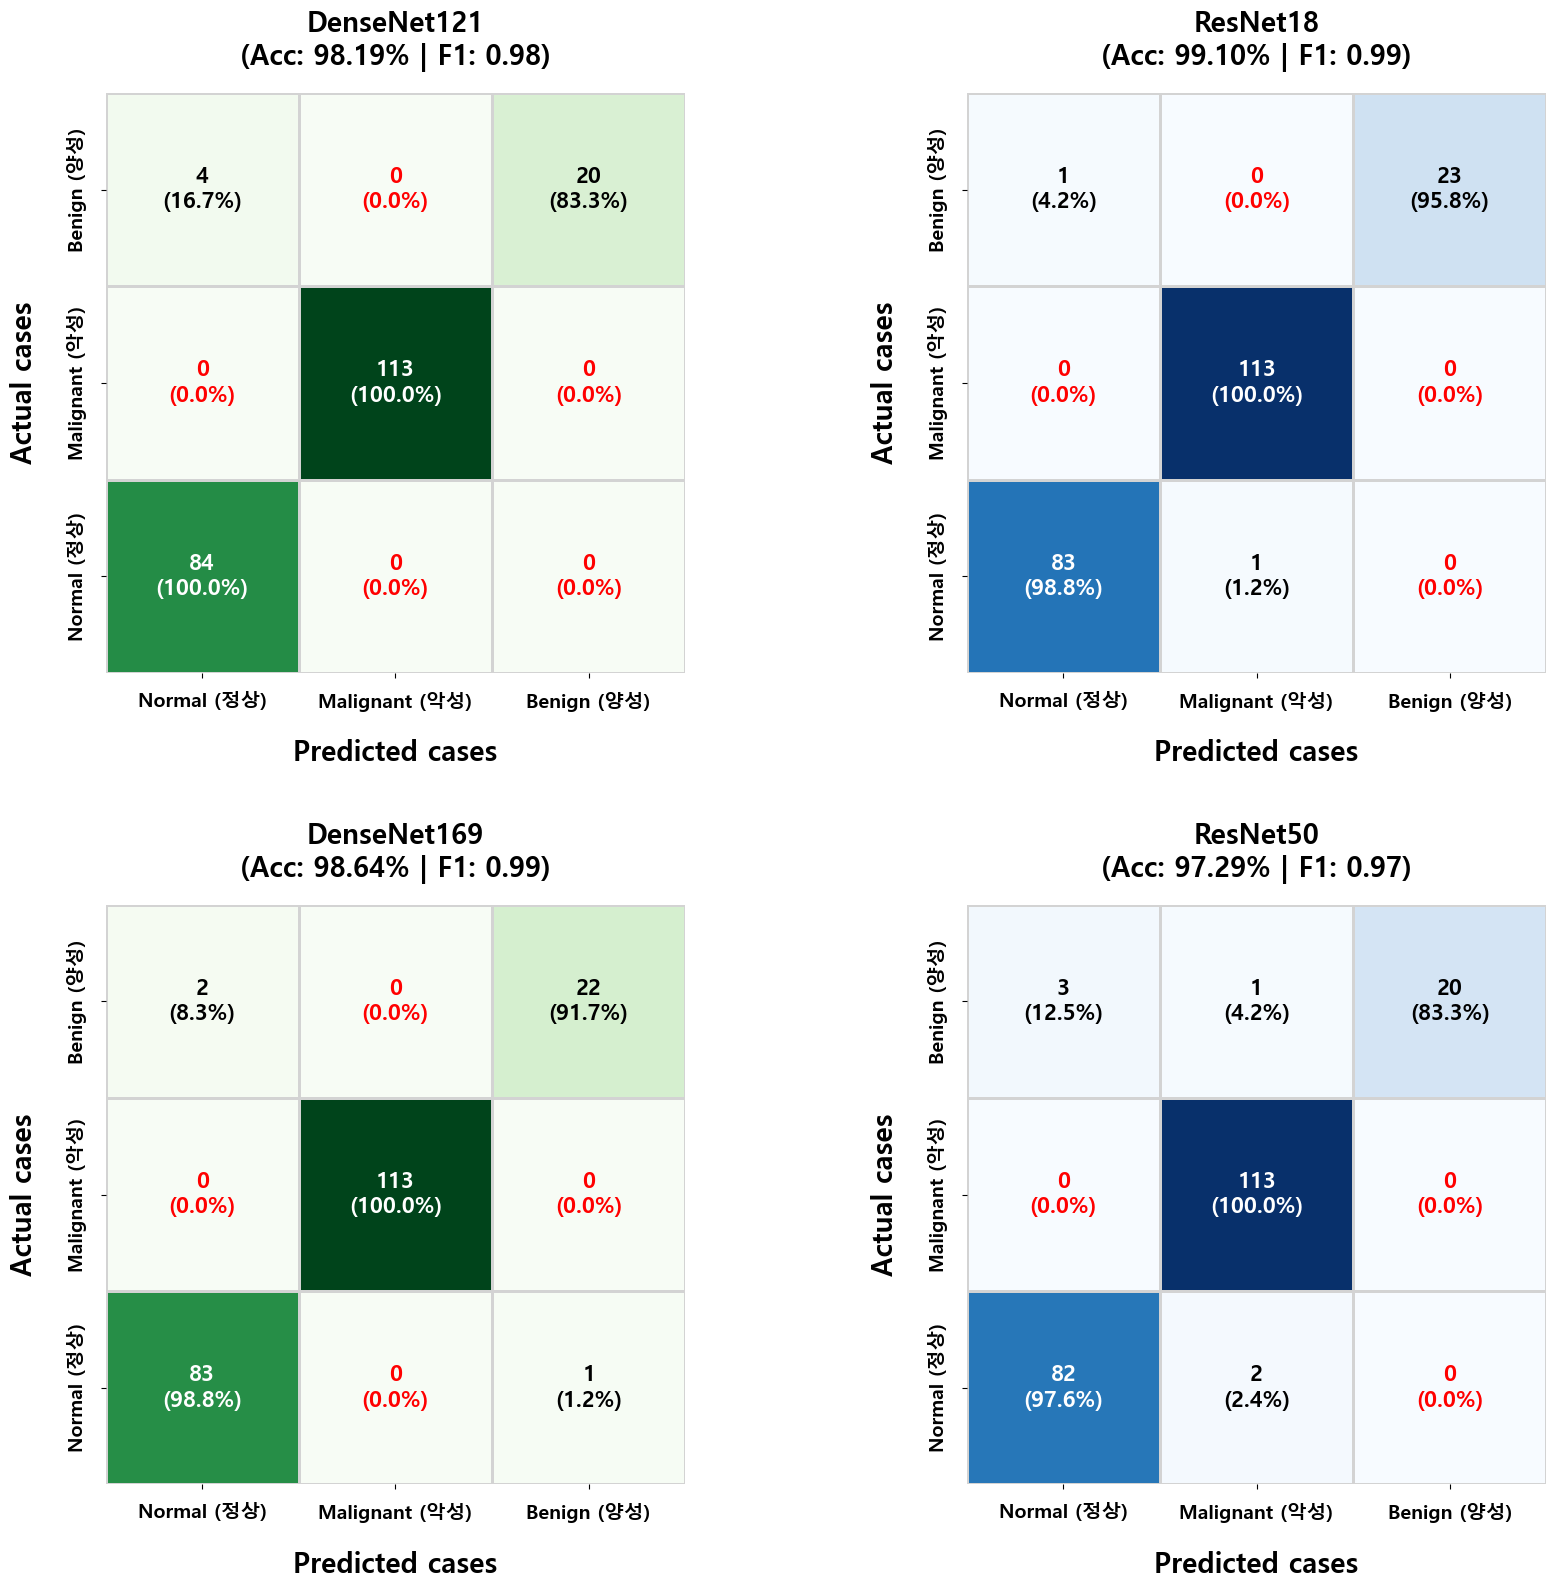

>> 그래프 저장 완료: ./Result_Comparison/confusion_matrices_final_v3.png


In [112]:
# [Cell 8] Confusion Matrix Visualization (Final: Spaced Labels)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import numpy as np
import os
import torch

def plot_confusion_matrices_final_v3(dataloaders, class_names):
    # 2x2 배치 설정
    grid_models = [
        ['densenet121', 'resnet18'],
        ['densenet169', 'resnet50']
    ]
    
    cmaps = [
        ['Greens', 'Blues'],
        ['Greens', 'Blues']
    ]
    
    # 모델명 매핑
    model_pretty_names = {
        'densenet121': 'DenseNet121',
        'densenet169': 'DenseNet169',
        'resnet18': 'ResNet18',
        'resnet50': 'ResNet50'
    }
    
    # 1. 라벨 매핑 (Normal -> Malignant -> Benign)
    target_order = ['Normal', 'Malignant', 'Benign']
    display_names = {
        'Normal': 'Normal (정상)',
        'Malignant': 'Malignant (악성)',
        'Benign': 'Benign (양성)'
    }
    
    reorder_idx = []
    final_display_labels = []
    
    for target in target_order:
        found = [name for name in class_names if target.lower() in name.lower()]
        if found:
            original_name = found[0]
            reorder_idx.append(class_names.index(original_name))
            final_display_labels.append(display_names[target])
        else:
            print(f"경고: '{target}' 클래스를 찾을 수 없습니다.")
    
    if len(reorder_idx) != 3:
        reorder_idx = range(len(class_names))
        final_display_labels = class_names

    # 2. 정답 데이터 로드
    y_true_raw = []
    for _, y in dataloaders['test']:
        y_true_raw.extend(y.numpy())
    y_true_raw = np.array(y_true_raw)
    
    # 3. 그래프 생성
    fig, axes = plt.subplots(2, 2, figsize=(16, 16))
    
    for row in range(2):
        for col in range(2):
            model_name = grid_models[row][col]
            cmap_name = cmaps[row][col]
            ax = axes[row][col]
            
            pth_path = f'./Result_Comparison/best_{model_name}.pth'
            
            if not os.path.exists(pth_path):
                ax.text(0.5, 0.5, "Model Not Found", ha='center', va='center')
                continue
            
            # 모델 로드 & 예측
            model = ModelFactory.get_model(model_name, len(class_names))
            model.load_state_dict(torch.load(pth_path))
            model.eval()
            model.to(DEVICE)
            
            y_pred_raw = []
            with torch.no_grad():
                for x, _ in dataloaders['test']:
                    x = x.to(DEVICE)
                    out = model(x)
                    y_pred_raw.extend(out.argmax(1).cpu().numpy())
            
            # 혼동 행렬
            cm_raw = confusion_matrix(y_true_raw, y_pred_raw)
            cm_ordered = cm_raw[np.ix_(reorder_idx, reorder_idx)]
            row_sums = cm_ordered.sum(axis=1)
            
            # 히트맵
            sns.heatmap(cm_ordered, annot=False, fmt='', cmap=cmap_name, ax=ax,
                        xticklabels=final_display_labels, 
                        yticklabels=final_display_labels, 
                        cbar=False, 
                        square=True, 
                        linewidths=1, linecolor='lightgray')
            
            # 텍스트 추가
            for i in range(cm_ordered.shape[0]):
                for j in range(cm_ordered.shape[1]):
                    count = cm_ordered[i, j]
                    total_actual = row_sums[i]
                    ratio = (count / total_actual * 100) if total_actual > 0 else 0
                    text_val = f"{count}\n({ratio:.1f}%)"
                    
                    text_color = "black"
                    if count == 0: text_color = "red"
                    elif count > cm_ordered.max() * 0.5: text_color = "white"
                        
                    ax.text(j + 0.5, i + 0.5, text_val, 
                            ha="center", va="center", 
                            color=text_color, fontsize=16, fontweight='bold')

            # Y축 역순
            ax.invert_yaxis()
            
            # [수정 1] 눈금 라벨(Text)과 히트맵 사이 간격 벌리기 (pad=10)
            ax.tick_params(axis='x', pad=10) 
            ax.tick_params(axis='y', pad=10)
            
            # 축 라벨 설정
            ax.set_yticklabels(final_display_labels, rotation=90, va='center', fontsize=14, fontweight='bold')
            ax.set_xticklabels(final_display_labels, rotation=0, ha='center', fontsize=14, fontweight='bold')
            
            # [수정 2] 축 제목(Predicted Label)과 눈금 라벨 사이 간격 벌리기 (labelpad=20)
            ax.set_xlabel("Predicted cases", fontsize=20, fontweight='bold', labelpad=20)
            ax.set_ylabel("Actual cases", fontsize=20, fontweight='bold', labelpad=20)
            
            # 타이틀
            acc = accuracy_score(y_true_raw, y_pred_raw)
            f1 = f1_score(y_true_raw, y_pred_raw, average='weighted')
            display_name = model_pretty_names.get(model_name, model_name)
            
            ax.set_title(f"{display_name}\n(Acc: {acc:.2%} | F1: {f1:.2f})", 
                         fontsize=20, fontweight='bold', pad=20)

    # 간격 조정
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    
    save_path = './Result_Comparison/confusion_matrices_final_v3.png'
    plt.savefig(save_path, dpi=300)
    plt.show()
    print(f">> 그래프 저장 완료: {save_path}")

# 실행
plot_confusion_matrices_final_v3(dataloaders, class_names)

In [101]:
# [Cell 9] 모델별 예측 결과 시각화 및 저장 (모든 이미지 저장)
import math

def visualize_all_predictions():
    # 1. 저장 경로 설정
    SAVE_DIR = './Result_Visuals'
    os.makedirs(SAVE_DIR, exist_ok=True)
    
    # 2. 시각화할 모델 리스트
    models_list = ['resnet18', 'resnet50', 'densenet121', 'densenet169']
    
    # 역정규화 (Un-normalization) 함수
    def inverse_normalize(tensor):
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = tensor.numpy().transpose((1, 2, 0)) # CHW -> HWC
        img = std * img + mean
        img = np.clip(img, 0, 1)
        return img

    print(f"=== 모든 테스트 결과 시각화 시작 ===")

    for model_name in models_list:
        print(f">> Processing {model_name}...")
        
        # 모델 로드
        pth_path = f'./Result_Comparison/best_{model_name}.pth'
        if not os.path.exists(pth_path):
            print(f"   [Skip] 가중치 파일 없음: {pth_path}")
            continue
            
        model = ModelFactory.get_model(model_name, len(class_names))
        model.load_state_dict(torch.load(pth_path))
        model.eval()
        
        # 테스트 데이터셋 파일 경로
        test_samples = dataloaders['test'].dataset.samples 
        
        # 데이터 수집용 리스트
        inputs_list, labels_list, preds_list, fnames_list = [], [], [], []
        current_page = 1
        batch_size_visual = 16 # 4x4
        
        with torch.no_grad():
            # 전체 데이터셋 순회
            iterator = tqdm(enumerate(dataloaders['test']), 
                            total=len(dataloaders['test']), 
                            desc=f"Generating Images", leave=False)
            
            for i, (inputs, labels) in iterator:
                inputs = inputs.to(DEVICE)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                
                for j in range(inputs.size(0)):
                    global_idx = i * dataloaders['test'].batch_size + j
                    if global_idx >= len(test_samples): break
                    
                    full_path = test_samples[global_idx][0]
                    file_name = os.path.basename(full_path)
                    
                    inputs_list.append(inputs[j].cpu())
                    labels_list.append(class_names[labels[j]])
                    preds_list.append(class_names[preds[j]])
                    fnames_list.append(file_name)
                    
                    # 16장이 모이면 저장
                    if len(inputs_list) == batch_size_visual:
                        save_grid_image(inputs_list, labels_list, preds_list, fnames_list, 
                                      model_name, current_page, SAVE_DIR, batch_size_visual)
                        # 초기화
                        inputs_list, labels_list, preds_list, fnames_list = [], [], [], []
                        current_page += 1
            
            # [중요] 마지막에 남은 이미지 처리 (Remainder)
            if len(inputs_list) > 0:
                save_grid_image(inputs_list, labels_list, preds_list, fnames_list, 
                              model_name, current_page, SAVE_DIR, batch_size_visual)

    print(f"\n>> 모든 시각화 이미지가 '{SAVE_DIR}' 폴더에 저장되었습니다.")

def save_grid_image(inputs, actuals, preds, fnames, model_name, page_num, save_dir, grid_size):
    """그리드 이미지를 생성하고 저장하는 헬퍼 함수"""
    fig = plt.figure(figsize=(16, 16))
    
    num_images = len(inputs)
    
    for idx in range(num_images):
        ax = fig.add_subplot(4, 4, idx + 1)
        img = inverse_normalize_helper(inputs[idx]) # 아래 헬퍼 함수 사용
        ax.imshow(img)
        
        actual = actuals[idx]
        prediction = preds[idx]
        fname = fnames[idx]
        
        if actual == prediction:
            color = 'green'
            status = '(O)'
        else:
            color = 'red'
            status = '(X)'
        
        title_text = f"[{fname}]\nAct: {actual}\nPred: {prediction} {status}"
        ax.set_title(title_text, color=color, fontsize=10, fontweight='bold')
        ax.axis('off')
    
    # 남은 빈 칸(subplot) 끄기
    for idx in range(num_images, grid_size):
        ax = fig.add_subplot(4, 4, idx + 1)
        ax.axis('off')

    plt.suptitle(f"Model: {model_name} | Page: {page_num}", fontsize=20, fontweight='bold', y=0.95)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    save_name = f"{save_dir}/{model_name}_page_{page_num}.png"
    plt.savefig(save_name)
    plt.close()

def inverse_normalize_helper(tensor):
    """텐서를 이미지로 변환"""
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = tensor.numpy().transpose((1, 2, 0))
    img = std * img + mean
    img = np.clip(img, 0, 1)
    return img

# 실행
visualize_all_predictions()

=== 모든 테스트 결과 시각화 시작 ===
>> Processing resnet18...


C:\Users\sjowu\AppData\Local\Temp\ipykernel_34656\1322654785.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(pth_path))


Generating Images:   0%|          | 0/7 [00:00<?, ?it/s]

>> Processing resnet50...


Generating Images:   0%|          | 0/7 [00:00<?, ?it/s]

>> Processing densenet121...


Generating Images:   0%|          | 0/7 [00:00<?, ?it/s]

>> Processing densenet169...


Generating Images:   0%|          | 0/7 [00:00<?, ?it/s]


>> 모든 시각화 이미지가 './Result_Visuals' 폴더에 저장되었습니다.
